In [39]:
import numpy as np
import pandas as pd
# import geopandas as gpd
# import requests
# import seaborn as sns
import skimage as ski
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier #
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
import math

## import file

In [2]:
airlines = pd.read_csv('airlines.csv')
airports = pd.read_csv('airports.csv')
flights = pd.read_csv('flights.csv', low_memory=False)
# states = gpd.read_file('test/cb_2018_us_state_500k.shp')

In [ ]:
# flights[(flights['MONTH']==10) & (flights['ORIGIN_AIRPORT']=='SEA')]
# a = flights.loc[:, ['MONTH', 'ABBR_AIRLINE', 'ORIGIN_AIRPORT',
#                 'DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME',
#                 'ELAPSED_TIME', 'DISTANCE', 'TAXI_IN', 'ARRIVAL_DELAY',
#                 'DESTINATION_AIRPORT']]
# a.head()

In [33]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## merging data

In [3]:
flights = flights.rename(columns={'AIRLINE': 'ABBR_AIRLINE'})
new_df = flights.merge(airlines, left_on='ABBR_AIRLINE', right_on='IATA_CODE',
                    how='left')
new_df = new_df.merge(airports, left_on='DESTINATION_AIRPORT',
                    right_on='IATA_CODE', how='left')
new_df = new_df.loc[:, ['MONTH', 'ABBR_AIRLINE', 'ORIGIN_AIRPORT',
                    'DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME',
                    'ELAPSED_TIME', 'DISTANCE', 'TAXI_IN', 'ARRIVAL_DELAY',
                    'DESTINATION_AIRPORT', 'AIRPORT', 'STATE', 'AIRLINE']]
new_df = new_df[(new_df['ORIGIN_AIRPORT']=='BLI') | \
              (new_df['ORIGIN_AIRPORT']=='GEG') | \
              (new_df['ORIGIN_AIRPORT']=='PSC') | \
              (new_df['ORIGIN_AIRPORT']=='SEA')]
new_df = new_df[new_df['MONTH'] != 10]
Delay_ratio_time = new_df['DEPARTURE_DELAY'] / new_df['SCHEDULED_TIME']
Delay_ratio_distance = new_df['DEPARTURE_DELAY'] / new_df['DISTANCE']
new_df['DELAY_RATIO_TIME'] = Delay_ratio_time
new_df['DELAY_RATIO_DISTANCE'] = Delay_ratio_distance

## define seriously delay

In [4]:
standard1 = new_df['DELAY_RATIO_TIME'].quantile(0.75)
standard2 = new_df['DELAY_RATIO_TIME'].mean() + new_df['DELAY_RATIO_TIME'].std()
standard = 0.5 * standard1 + 0.5 * standard2

print(standard)
new_df['SERIOUSLY_DELAY'] = new_df['DELAY_RATIO_TIME'].apply(lambda x: False if x < standard else True)
new_df

0.153067506792865


,MONTH,ABBR_AIRLINE,ORIGIN_AIRPORT,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE,TAXI_IN,ARRIVAL_DELAY,DESTINATION_AIRPORT,AIRPORT,STATE,AIRLINE,DELAY_RATIO_TIME,DELAY_RATIO_DISTANCE,SERIOUSLY_DELAY
4,1,AS,SEA,-1.0,11.0,235.0,215.0,1448,5.0,-21.0,ANC,Ted Stevens Anchorage International Airport,AK,Alaska Airlines Inc.,-0.004255,-0.000691,False
14,1,DL,SEA,-1.0,28.0,189.0,198.0,1399,4.0,8.0,MSP,Minneapolis-Saint Paul International Airport,MN,Delta Air Lines Inc.,-0.005291,-0.000715,False
21,1,AA,SEA,-8.0,30.0,338.0,347.0,2724,6.0,1.0,MIA,Miami International Airport,FL,American Airlines Inc.,-0.023669,-0.002937,False
57,1,AS,GEG,-4.0,22.0,70.0,74.0,224,13.0,0.0,SEA,Seattle-Tacoma International Airport,WA,Alaska Airlines Inc.,-0.057143,-0.017857,False
69,1,US,SEA,-5.0,15.0,165.0,168.0,1107,7.0,-2.0,PHX,Phoenix Sky Harbor International Airport,AZ,US Airways Inc.,-0.030303,-0.004517,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819025,12,B6,SEA,-2.0,12.0,306.0,308.0,2496,4.0,0.0,BOS,Gen. Edward Lawrence Logan International Airport,MA,JetBlue Airways,-0.006536,-0.000801,False
5819038,12,AS,SEA,2.0,11.0,220.0,224.0,1660,7.0,6.0,DFW,Dallas/Fort Worth International Airport,TX,Alaska Airlines Inc.,0.009091,0.001205,False
5819051,12,AS,SEA,16.0,10.0,192.0,204.0,1399,5.0,28.0,MSP,Minneapolis-Saint Paul International Airport,MN,Alaska Airlines Inc.,0.083333,0.011437,False
5819053,12,AS,SEA,0.0,11.0,236.0,209.0,1448,4.0,-27.0,ANC,Ted Stevens Anchorage International Airport,AK,Alaska Airlines Inc.,0.000000,0.000000,False


## Exploring data

In [12]:
new_df[new_df['SERIOUSLY_DELAY'] == 0]

,MONTH,ABBR_AIRLINE,ORIGIN_AIRPORT,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE,TAXI_IN,ARRIVAL_DELAY,DESTINATION_AIRPORT,AIRPORT,STATE,AIRLINE,DELAY_RATIO_TIME,DELAY_RATIO_DISTANCE,SERIOUSLY_DELAY
4,1,AS,SEA,-1.0,11.0,235.0,215.0,1448,5.0,-21.0,ANC,Ted Stevens Anchorage International Airport,AK,Alaska Airlines Inc.,-0.004255,-0.000691,False
14,1,DL,SEA,-1.0,28.0,189.0,198.0,1399,4.0,8.0,MSP,Minneapolis-Saint Paul International Airport,MN,Delta Air Lines Inc.,-0.005291,-0.000715,False
21,1,AA,SEA,-8.0,30.0,338.0,347.0,2724,6.0,1.0,MIA,Miami International Airport,FL,American Airlines Inc.,-0.023669,-0.002937,False
57,1,AS,GEG,-4.0,22.0,70.0,74.0,224,13.0,0.0,SEA,Seattle-Tacoma International Airport,WA,Alaska Airlines Inc.,-0.057143,-0.017857,False
69,1,US,SEA,-5.0,15.0,165.0,168.0,1107,7.0,-2.0,PHX,Phoenix Sky Harbor International Airport,AZ,US Airways Inc.,-0.030303,-0.004517,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819025,12,B6,SEA,-2.0,12.0,306.0,308.0,2496,4.0,0.0,BOS,Gen. Edward Lawrence Logan International Airport,MA,JetBlue Airways,-0.006536,-0.000801,False
5819038,12,AS,SEA,2.0,11.0,220.0,224.0,1660,7.0,6.0,DFW,Dallas/Fort Worth International Airport,TX,Alaska Airlines Inc.,0.009091,0.001205,False
5819051,12,AS,SEA,16.0,10.0,192.0,204.0,1399,5.0,28.0,MSP,Minneapolis-Saint Paul International Airport,MN,Alaska Airlines Inc.,0.083333,0.011437,False
5819053,12,AS,SEA,0.0,11.0,236.0,209.0,1448,4.0,-27.0,ANC,Ted Stevens Anchorage International Airport,AK,Alaska Airlines Inc.,0.000000,0.000000,False


In [15]:
new_df.loc[:, ['DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'DISTANCE', 'TAXI_IN', 'ARRIVAL_DELAY']].describe()
               

,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE,TAXI_IN,ARRIVAL_DELAY
count,123053.000000,123028.000000,123548.000000,122716.000000,123548.000000,122970.000000,122716.000000
mean,6.539239,16.485865,180.119006,176.414323,1205.000615,6.810466,2.890080
std,30.742411,6.270696,77.316544,75.956063,665.774673,4.880995,32.494122
min,-32.000000,1.000000,37.000000,31.000000,93.000000,1.000000,-72.000000
25%,-5.000000,12.000000,128.000000,124.000000,689.000000,4.000000,-12.000000
50%,-2.000000,15.000000,160.000000,157.000000,1020.000000,5.000000,-3.000000
75%,5.000000,19.000000,231.000000,224.000000,1660.000000,8.000000,7.000000
max,1304.000000,120.000000,405.000000,462.000000,2724.000000,165.000000,1301.000000


In [13]:

new_df.groupby('STATE')['ARRIVAL_DELAY'].mean().sort_values()         
               

STATE
SC   -18.692308
OK   -16.934211
NM   -13.412776
LA    -4.924699
MD    -4.584906
VA    -3.487627
KY    -3.457364
OH    -2.846667
FL    -2.167243
GA    -1.395489
HI    -0.965684
WI    -0.942164
MI    -0.343386
NJ    -0.060160
UT     0.623565
PA     1.602249
AZ     2.161378
AK     2.169483
MN     2.390025
MT     2.414286
IL     2.664521
ID     2.813559
MO     2.894628
TN     3.108696
NV     3.422492
NC     3.599099
MA     3.737127
NY     4.114217
CA     4.184276
TX     4.595705
CO     4.596265
OR     5.750136
WA     5.940008
NE     6.461078
WY    16.809524
Name: ARRIVAL_DELAY, dtype: float64

In [14]:
new_df.groupby('MONTH')['ARRIVAL_DELAY'].mean().sort_values()

MONTH
4    -0.193361
2     0.280714
9     0.329396
3     0.950713
5     2.512663
11    3.525386
6     3.576384
1     3.926943
7     4.024392
12    5.224584
8     6.032036
Name: ARRIVAL_DELAY, dtype: float64

## DecisionTreeRegression

ValueError: y_true and y_pred have different number of output (107!=1)

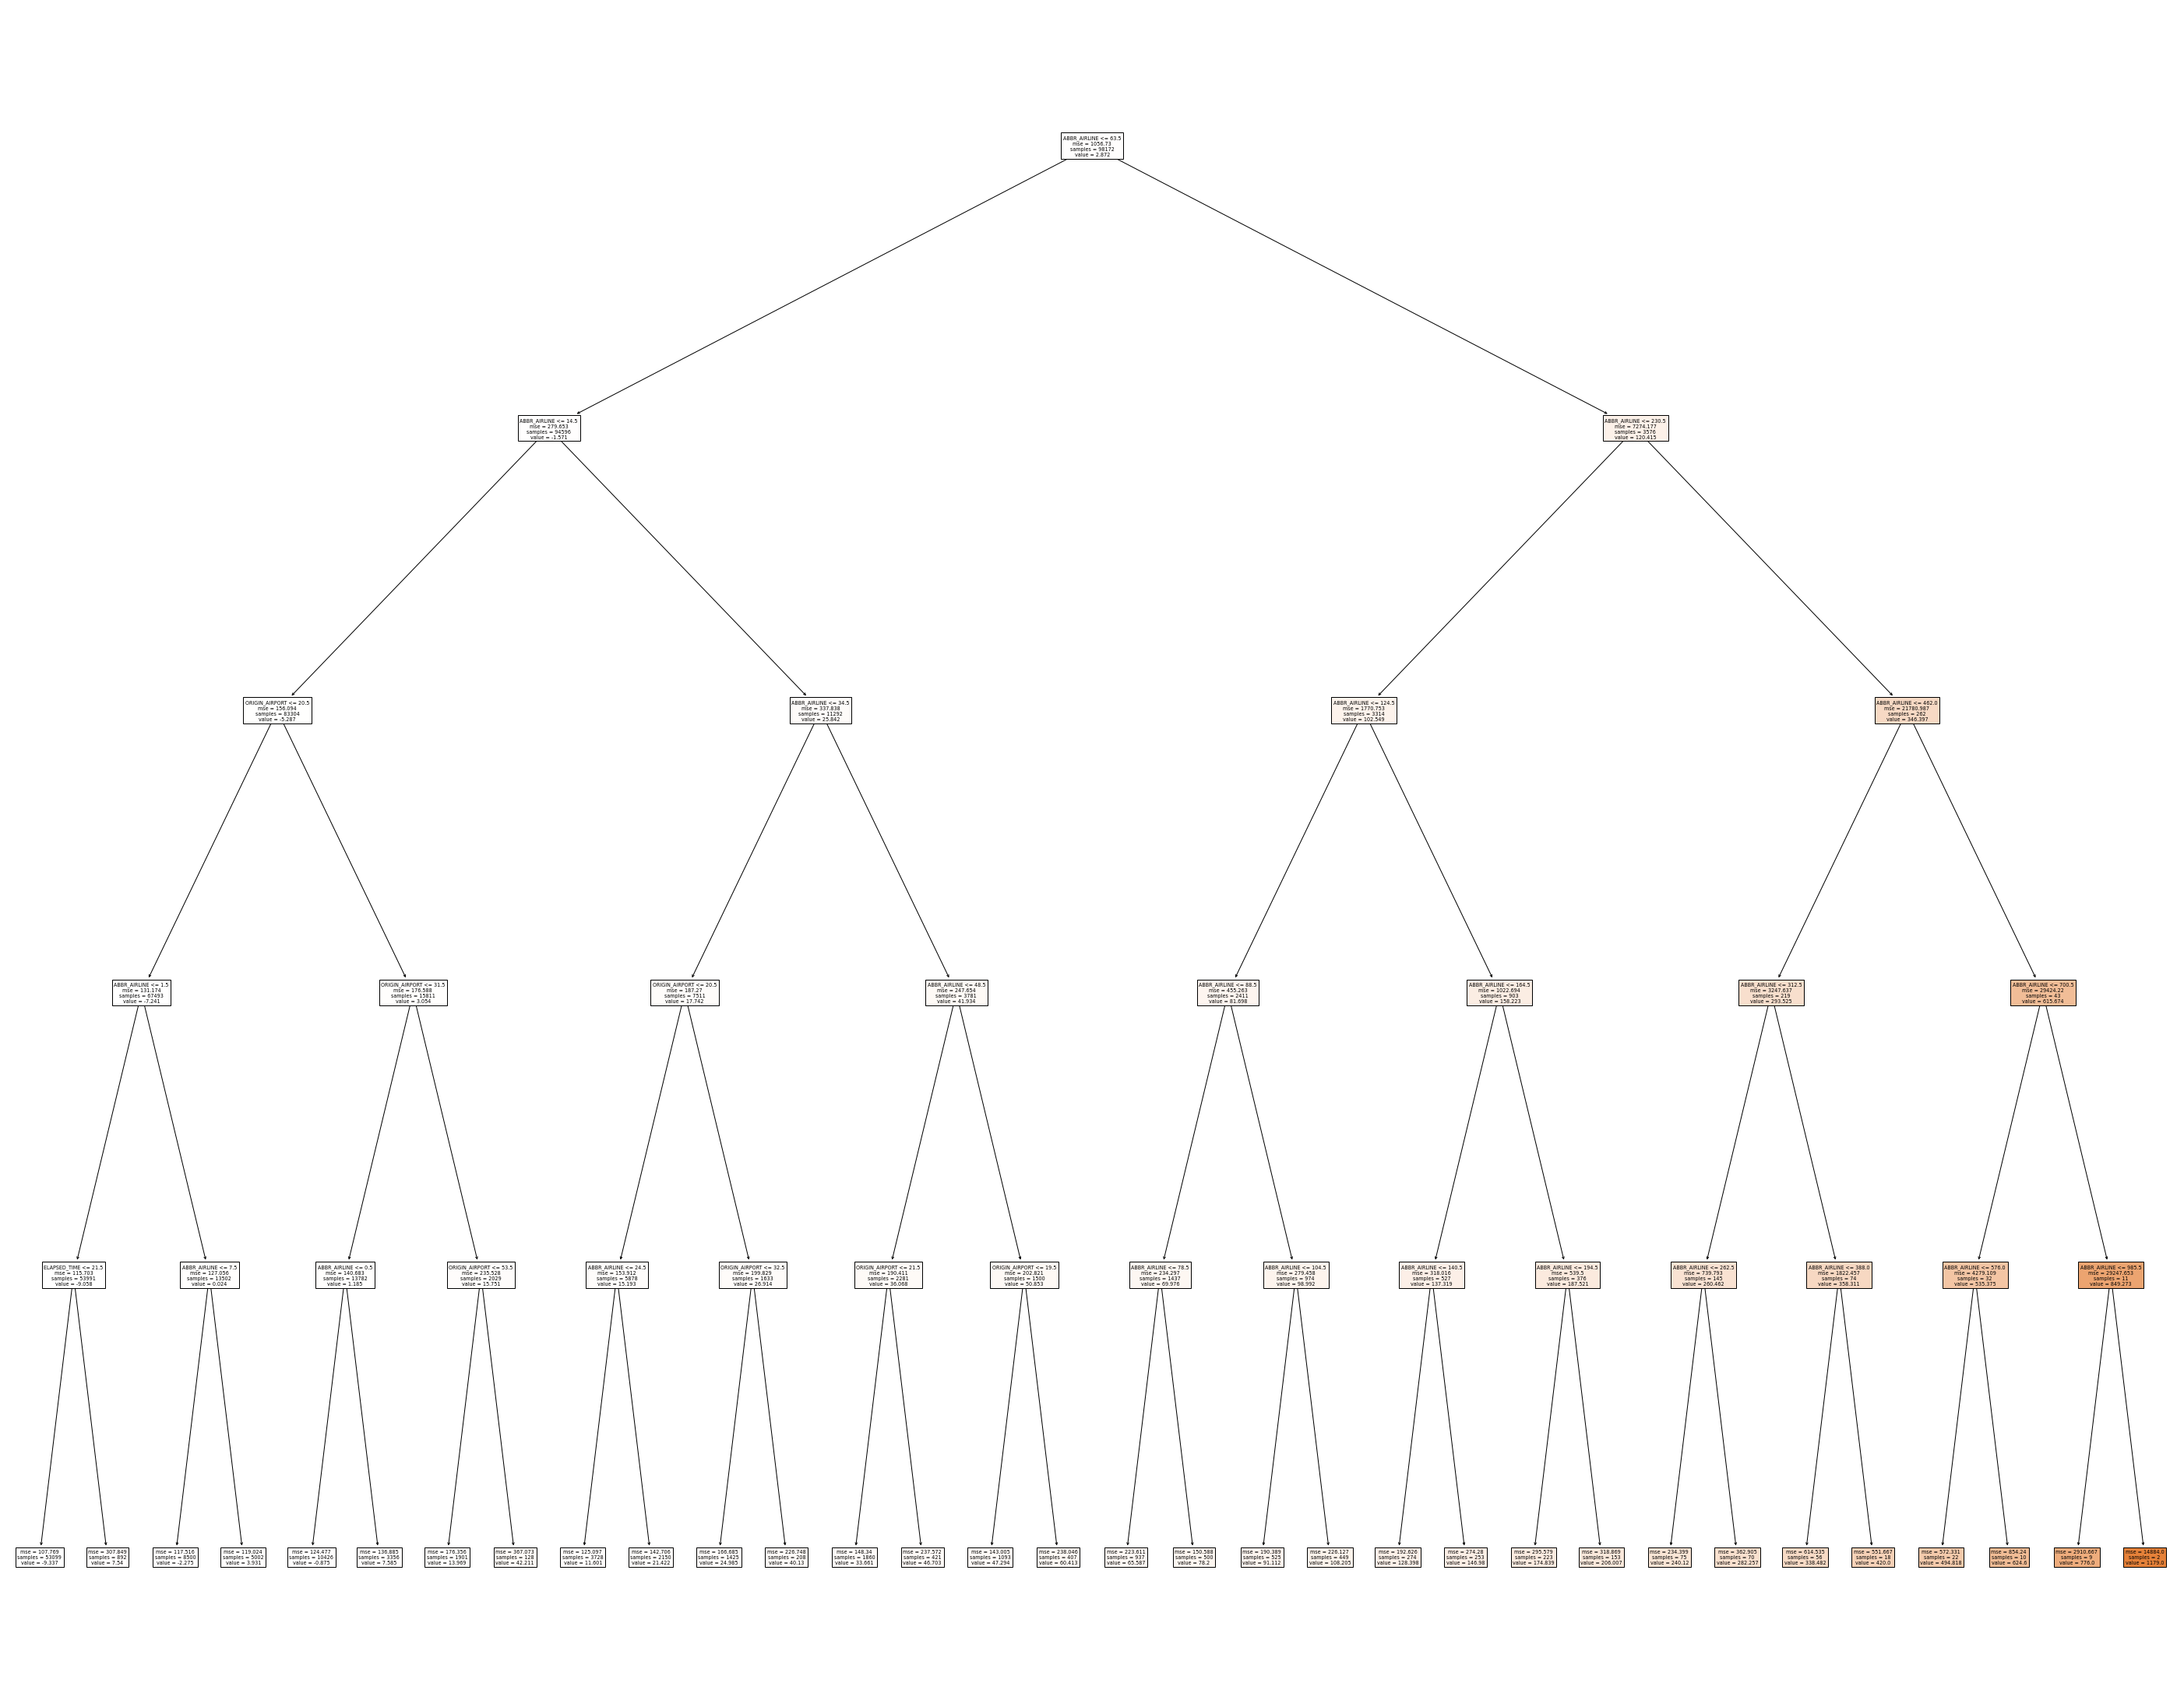

In [13]:
# new_df = new_df.sample(frac=0.4)
data = new_df.loc[:, ['MONTH', 'ABBR_AIRLINE', 'ORIGIN_AIRPORT','DEPARTURE_DELAY',
            'TAXI_OUT', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'DISTANCE',
            'TAXI_IN', 'ARRIVAL_DELAY', 'DESTINATION_AIRPORT', 'AIRLINE']].dropna()
features = data.loc[:, data.columns != 'ARRIVAL_DELAY']
features = pd.get_dummies(features)
labels = data['ARRIVAL_DELAY']
feat_train, feat_test, lab_train, lab_test = train_test_split(features, labels, test_size=0.2)

model = DecisionTreeRegressor(max_depth = 5)
model.fit(feat_train, lab_train)
fig = plt.figure(figsize=(50,40))
plot = plot_tree(model, feature_names=list(data.columns[:-1]), filled=True)

model = DecisionTreeRegressor(max_depth = 15)
model.fit(feat_train, lab_train)

train_predictions = model.predict(feat_train)
test_predictions = model.predict(feat_test)

# a = list(range(1,len(test_predictions)+1))
# plt.scatter(a, test_predictions, label = "test_prediction")

# plt.plot(tree_depth, test_accuracy, label = "test accuracy")
# plt.title('Train vs test mean squared error by tree depth')
# plt.xlabel('tree depth')
# plt.ylabel('mean squared error')
# plt.legend()
print(f"baseline for mse: {mean_squared_error(lab_train, ).mean()}")
    
train_accuracy = []
test_accuracy = []
for i in range(1, 20):
    model = DecisionTreeRegressor(max_depth = i)
    model.fit(feat_train, lab_train)

    train_predictions = model.predict(feat_train)
    test_predictions = model.predict(feat_test)
    train_error = mean_squared_error(lab_train, train_predictions)
    test_error = mean_squared_error(lab_test, test_predictions)

    train_accuracy.append(train_error)
    test_accuracy.append(test_error)
    print(i, train_error, test_error)

# tree_depth = list(range(1, 20))
# plt.plot(tree_depth, train_accuracy, label = "train accuracy")
# plt.plot(tree_depth, test_accuracy, label = "test accuracy")
# plt.title('Train vs test mean squared error by tree depth')
# plt.xlabel('tree depth')
# plt.ylabel('mean squared error')
# plt.legend()
# plt.show()

## DecisionTreeClassification

[[22019     7]
 [    5  2513]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     22026
        True       1.00      1.00      1.00      2518

    accuracy                           1.00     24544
   macro avg       1.00      1.00      1.00     24544
weighted avg       1.00      1.00      1.00     24544

1 0.9666401825367722 0.9647571707953064
2 0.9666401825367722 0.9647571707953064
3 0.9884692172920996 0.9876140808344198
4 0.9907916717597686 0.9899771838331161
5 0.9954875117141344 0.9955182529335072
6 0.9969543250621359 0.9960886571056062
7 0.9986656073014709 0.9977591264667536
8 0.9991749174917491 0.998085071707953
9 0.9997147862934441 0.9991443937418514
10 0.9997962759238886 0.9992666232073012
11 1.0 0.9994703389830508
12 1.0 0.9996333116036505
13 1.0 0.9995518252933507
14 1.0 0.999388852672751
15 1.0 0.999388852672751
16 1.0 0.9994295958279009
17 1.0 0.9994703389830508
18 1.0 0.9995925684485006
19 1.0 0.999388852672751


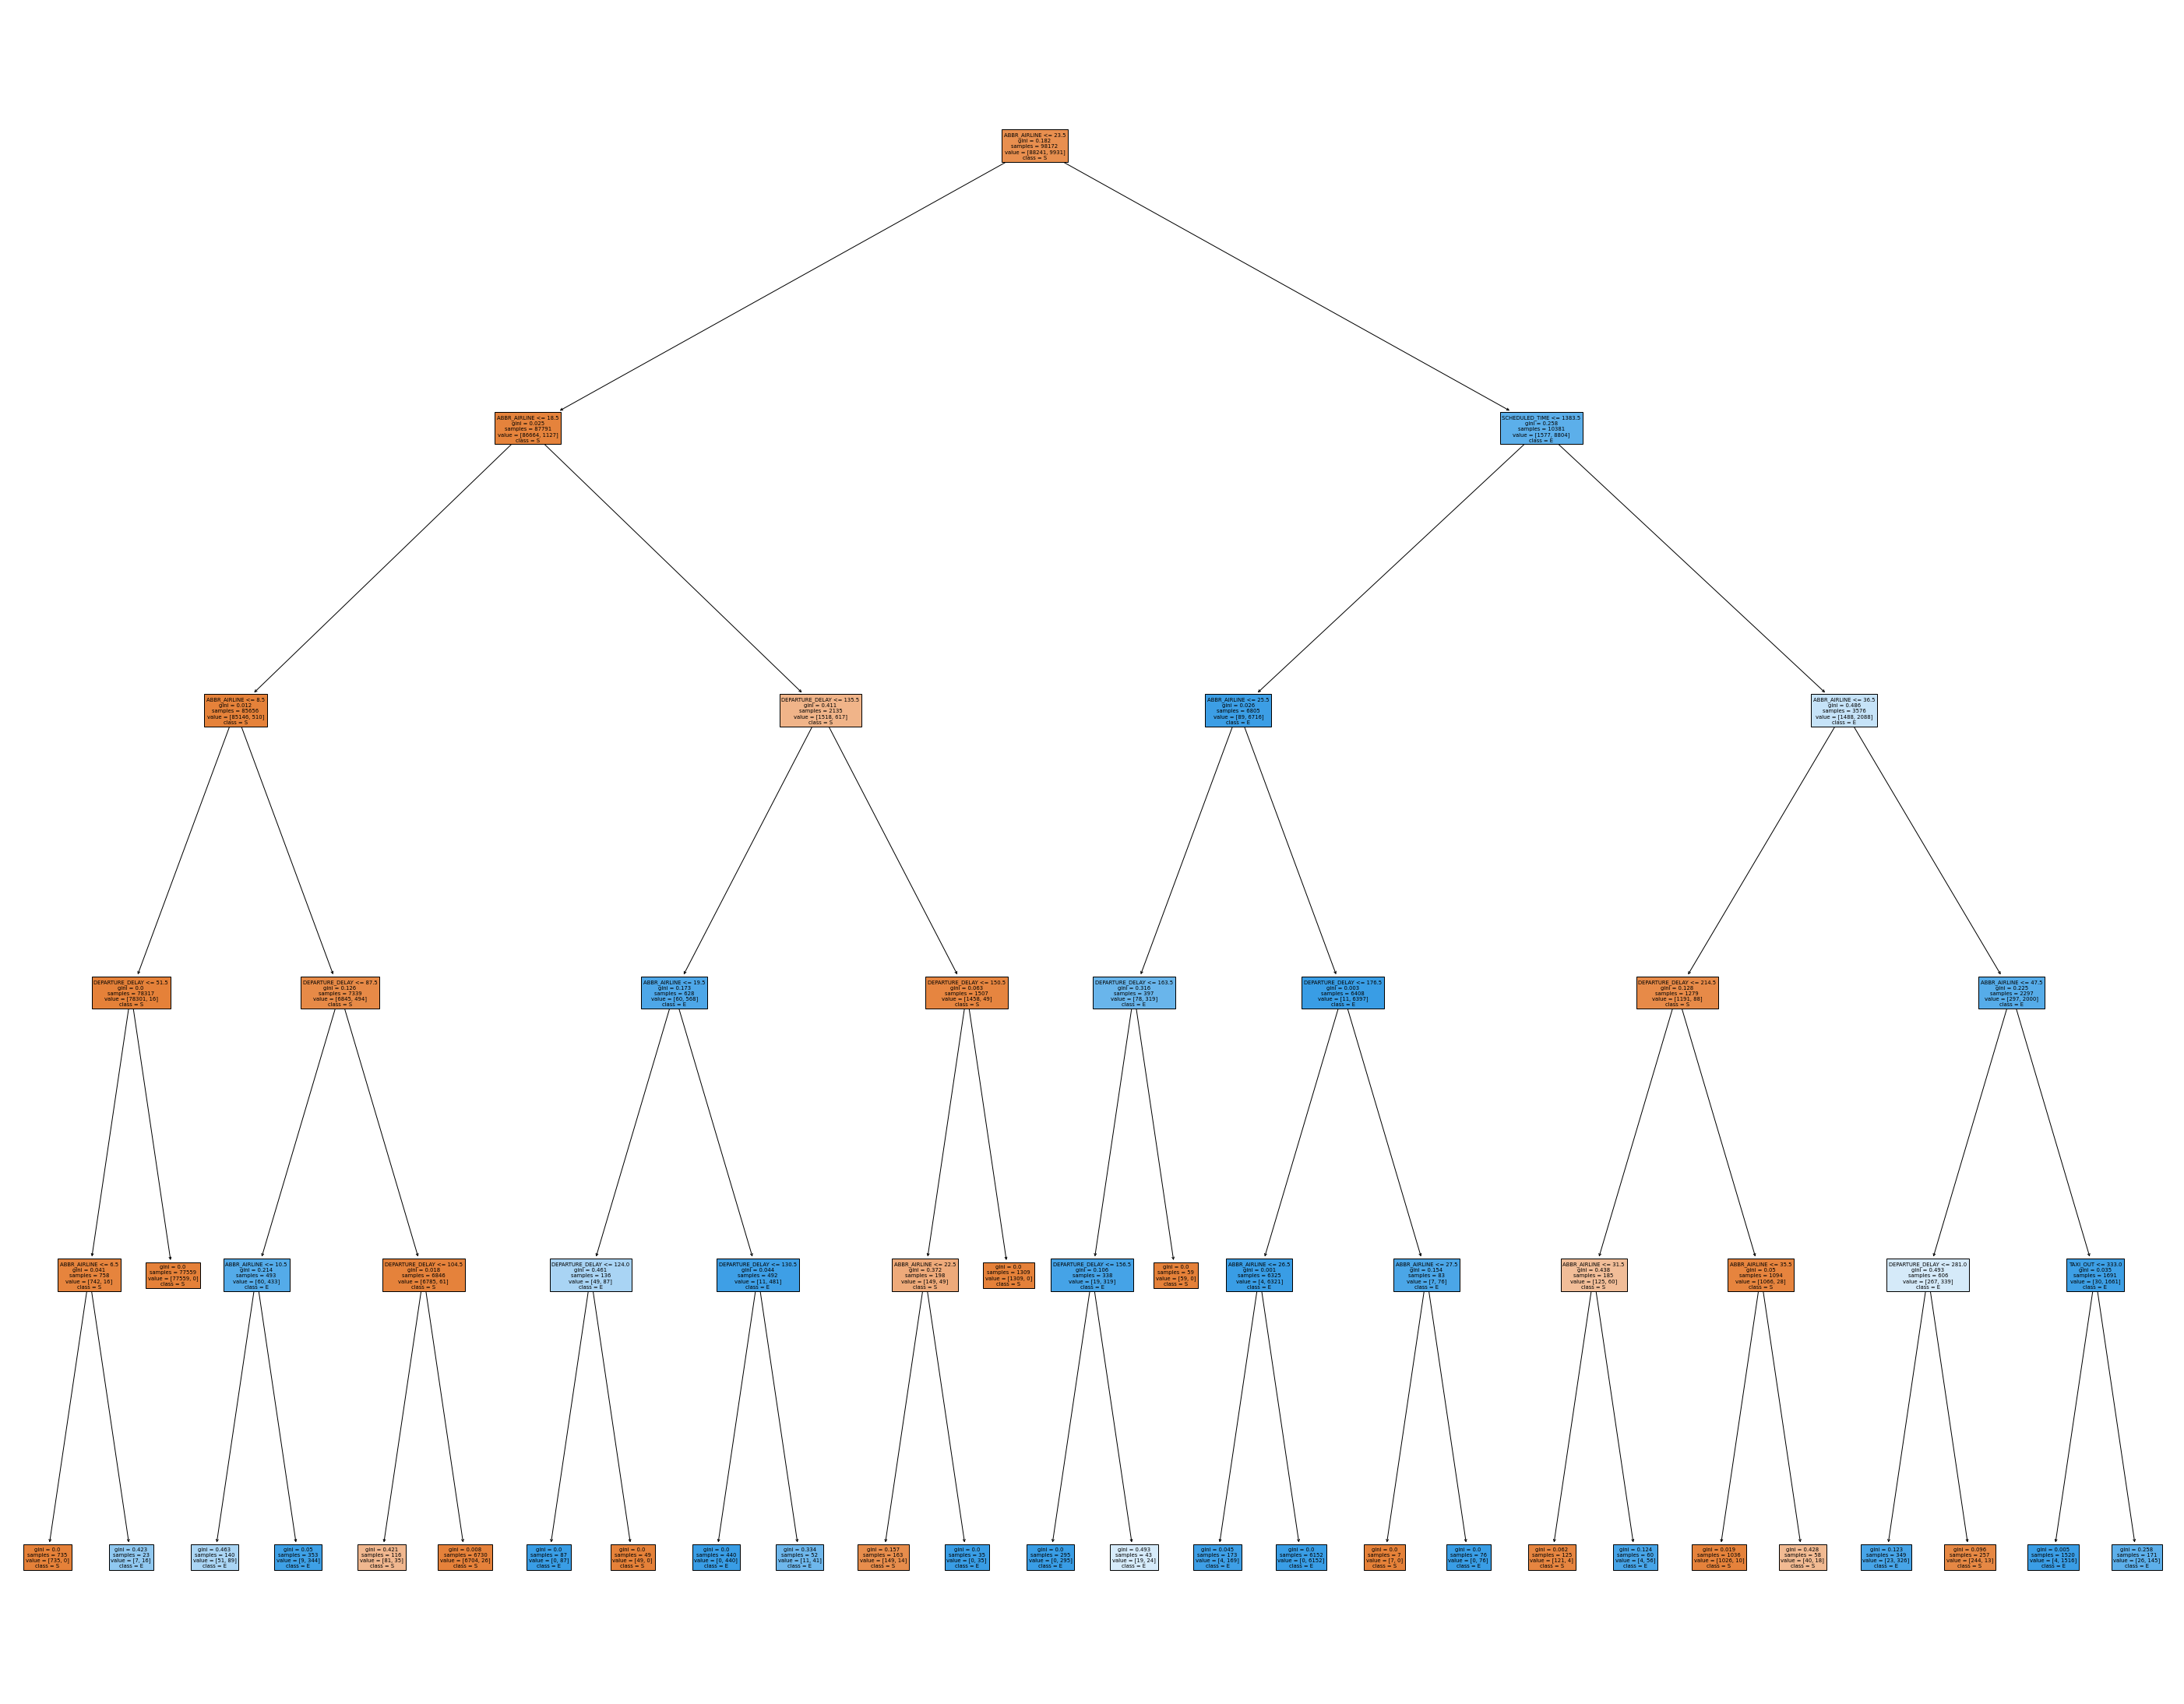

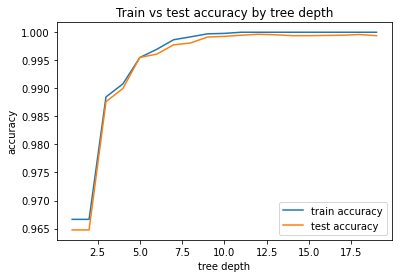

In [10]:
# new_df = new_df.sample(frac=0.3)
data = new_df.loc[:, ['SERIOUSLY_DELAY', 'MONTH', 'ABBR_AIRLINE', 'ORIGIN_AIRPORT','DEPARTURE_DELAY',
            'TAXI_OUT', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'DISTANCE', 'TAXI_IN',
            'DESTINATION_AIRPORT', 'AIRLINE']].dropna()
features = data.loc[:, data.columns != 'SERIOUSLY_DELAY']
features = pd.get_dummies(features)
labels = data['SERIOUSLY_DELAY']
feat_train, feat_test, lab_train, lab_test = train_test_split(features, labels, test_size=0.2, random_state=10)

model = DecisionTreeClassifier(max_depth = 14)
model.fit(feat_train, lab_train)
lab_pred = model.predict(feat_test)
print(confusion_matrix(lab_test, lab_pred))
print(classification_report(lab_test, lab_pred))

model = DecisionTreeClassifier(max_depth = 5)
model.fit(feat_train, lab_train)
fig1 = plt.figure(figsize=(50,40))
plot = plot_tree(model, feature_names=list(data.columns[1:]), class_names=list(data.columns[0]), filled=True)

train_accuracy = []
test_accuracy = []
for i in range(1, 20):
    model = DecisionTreeClassifier(criterion="entropy", max_depth = i)
    model.fit(feat_train, lab_train)
    
    train_error = model.score(feat_train, lab_train)
    test_error = model.score(feat_test, lab_test)
    
    train_accuracy.append(train_error)
    test_accuracy.append(test_error)
    print(i, train_error, test_error)
    
  ### line13  
tree_depth = list(range(1, 20))
fig2 = plt.figure()
plt.plot(tree_depth, train_accuracy, label = "train accuracy")
plt.plot(tree_depth, test_accuracy, label = "test accuracy")
plt.title('Train vs test accuracy by tree depth')
plt.xlabel('tree depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()
# plt.savefig('Train_vs_test_accuracy_by_tree_depth.png')

# dt = DecisionTreeClassifier(criterion="entropy", max_depth = 14, random_state=10)
# dt.fit(X_train, y_train)
# y_pred = dt.predict(X_test)
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

## Linear Regression

In [8]:
data = new_df[['MONTH', 'ABBR_AIRLINE', 'DEPARTURE_DELAY', 'ORIGIN_AIRPORT',
    'TAXI_OUT', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'DISTANCE',
    'TAXI_IN', 'DESTINATION_AIRPORT', 'AIRLINE', 'ARRIVAL_DELAY']].dropna()
X = data.loc[:, data.columns != 'ARRIVAL_DELAY']
X = pd.get_dummies(X)
X['intercept'] = 1
y = data[['ARRIVAL_DELAY']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 30)
ols = sm.OLS(y_train, X_train)
ols_result = ols.fit()
print("Linear Regression summary:")
print(ols_result.summary())

Linear Regression summary:
                            OLS Regression Results                            
Dep. Variable:          ARRIVAL_DELAY   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.939e+29
Date:                Sat, 04 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:58:20   Log-Likelihood:             2.5213e+06
No. Observations:               98172   AIC:                        -5.042e+06
Df Residuals:                   98078   BIC:                        -5.041e+06
Df Model:                          93                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

## Testing

In [9]:
df_100 = new_df.sample(n=100)
df_100

,MONTH,ABBR_AIRLINE,ORIGIN_AIRPORT,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE,TAXI_IN,ARRIVAL_DELAY,DESTINATION_AIRPORT,AIRPORT,STATE,AIRLINE,DELAY_RATIO_TIME,DELAY_RATIO_DISTANCE,SERIOUSLY_DELAY
2244457,5,DL,SEA,-3.0,10.0,155.0,144.0,954,12.0,-14.0,LAX,Los Angeles International Airport,CA,Delta Air Lines Inc.,-0.019355,-0.003145,False
4898068,11,WN,SEA,-5.0,14.0,140.0,143.0,867,6.0,-2.0,LAS,McCarran International Airport,NV,Southwest Airlines Co.,-0.035714,-0.005767,False
2950321,7,AS,SEA,21.0,12.0,142.0,143.0,909,4.0,22.0,JNU,Juneau International Airport,AK,Alaska Airlines Inc.,0.147887,0.023102,False
3411566,8,AS,SEA,-4.0,30.0,116.0,127.0,689,3.0,7.0,SLC,Salt Lake City International Airport,UT,Alaska Airlines Inc.,-0.034483,-0.005806,False
1145847,3,DL,SEA,-3.0,18.0,250.0,214.0,1927,4.0,-39.0,DTW,Detroit Metropolitan Airport,MI,Delta Air Lines Inc.,-0.012000,-0.001557,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1981161,5,AS,SEA,-2.0,12.0,234.0,234.0,1721,7.0,-2.0,ORD,Chicago O'Hare International Airport,IL,Alaska Airlines Inc.,-0.008547,-0.001162,False
432668,1,AS,SEA,-4.0,18.0,229.0,218.0,1448,3.0,-15.0,ANC,Ted Stevens Anchorage International Airport,AK,Alaska Airlines Inc.,-0.017467,-0.002762,False
4888306,11,AS,SEA,-6.0,12.0,120.0,120.0,672,5.0,-6.0,OAK,Oakland International Airport,CA,Alaska Airlines Inc.,-0.050000,-0.008929,False
3244129,7,OO,SEA,-4.0,54.0,240.0,260.0,1694,4.0,16.0,MKE,General Mitchell International Airport,WI,Skywest Airlines Inc.,-0.016667,-0.002361,False


In [64]:
y1 = []
y2 = []
a=5**(1/2)
for i in range (0,100):
    y1.append(1+4/3*i-1/2*(i**2)+1/6*(i**3))
    y2.append(math.log(1+4/3*i-1/2*(i**2)+1/6*(i**3)))
# math.log(1+4/3*i-1/2*(i**2)+1/6*(i**3))
# math.log((3+a)/(2*a)*((1+a)/2)**i-((3-a)/(2*a)*((1-a)/2)**i))

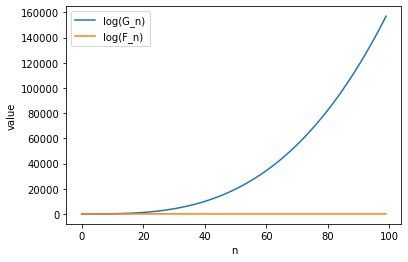

In [65]:
fig2 = plt.figure()
plt.plot(range(0,100), y1, label = "log(G_n)")
plt.plot(range(0,100), y2, label = "log(F_n)")
plt.xlabel('n')
plt.ylabel('value')
plt.legend()
plt.show()

[0.0,
 0.6931471805599452,
 1.0986122886681098,
 1.6094379124341003,
 2.0794415416798357,
 2.5649493574615367,
 3.044522437723423,
 3.5263605246161616,
 4.007333185232471,
 4.4886363697321405,
 4.969813299576001,
 5.451038453565701,
 5.932245187448011,
 6.413458957167357,
 6.894670039433482,
 7.3758821482150125,
 7.857093864902493,
 8.338305731356566,
 8.819517540604888,
 9.300729371703865,
 9.781941194456634,
 10.263153020397368,
 10.74436484512041,
 11.225576670308568,
 11.706788495319069,
 12.188000320397428,
 12.669212145449867,
 13.150423970512207,
 13.631635795570766,
 14.112847620630768,
 14.594059445690219,
 15.07527127074988,
 15.556483095809462,
 16.037694920869075,
 16.518906745928675,
 17.000118570988278,
 17.48133039604788,
 17.962542221107487,
 18.44375404616709,
 18.924965871226693,
 19.406177696286296,
 19.8873895213459,
 20.3686013464055,
 20.849813171465108,
 21.33102499652471,
 21.812236821584314,
 22.293448646643917,
 22.77466047170352,
 23.255872296763123,
 23.7370